# Introduction

In [ ]:
# Import built-in Python libraries
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from matplotlib import gridspec
from sklearn.preprocessing import label_binarize
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from shutil import copy

import tensorflow as tf
import numpy as np
import scipy.io.wavfile
import librosa
import glob
import os
import pickle
import time
import datetime
import importlib
import zipfile

In [ ]:
# Path variables
drive_path = "/content/drive/My Drive/KInsekten/"

data_path         = drive_path + "data/Potatamis/"
figures_path      = drive_path + "figures/"
scripts_path      = drive_path + "scripts/"
pot_models_path   = drive_path + "models/Potatamis/"
keogh_models_path = drive_path + "models/Keogh/"

# Plot font sizes
title_size = 32
label_size = 27
ticks_size = 27
fig_size   = (20, 14)

In [ ]:
strategy = 'CPU' #@param ["CPU", "GPU", "TPU"]

if strategy is 'CPU':
  strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
  print('/device:CPU:0')
elif strategy is 'GPU':
  if tf.config.list_physical_devices('GPU'):
    tf.test.gpu_device_name()
    strategy = tf.distribute.MirroredStrategy()
  else:
    print('No GPU detected')
elif strategy is 'TPU':
  try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
  except ValueError:
    print('No TPU detected')

/device:CPU:0


In [ ]:
os.chdir(drive_path)
import wingbeats
from wingbeats.modelling import *
from wingbeats.processing import *
from wingbeats.xai import *

# Load signals

In [ ]:
# Create temporary local directory to copy data from Drive 
os.chdir('/content')
if not os.path.exists('KInsekten'):
    os.mkdir('KInsekten')
if not os.path.exists('KInsekten/Potatamis'):
    os.mkdir('KInsekten/Potatamis')
if not os.path.exists('KInsekten/Potatamis/Test'): 
    os.mkdir('KInsekten/Potatamis/Test')
if not os.path.exists('KInsekten/Potatamis_zip'):
    os.mkdir('KInsekten/Potatamis_zip')
time.sleep(10) # wait until Colab creates the new directories

# Copy files from Drive (zipped amplitudes and label vectors)
start_time = time.time()
copy(data_path + 'Test_amplitudes.zip', 'KInsekten/Potatamis_zip')
print('Test_amplitudes.zip copied')
copy(data_path + 'Test_labels.pickle', 'KInsekten/Potatamis/Test')
print('Test_labels.pickle copied')
print("%s seconds\n" % int(time.time() - start_time))

# Unzip the files locally
start_time = time.time()
with zipfile.ZipFile('/content/KInsekten/Potatamis_zip/Test_amplitudes.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/KInsekten/Potatamis/Test')  
print('Test unzipped')
print("%s seconds\n" % int(time.time() - start_time))

Test_amplitudes.zip copied
Test_labels.pickle copied
11 seconds

Test unzipped
10 seconds



Species and Genus encoding

In [ ]:
# Dictionary of genera with the included species
genus_species_dict = {
    'Aedes': ['Ae_aegypti', 'Ae_albopictus'],
    'Anopheles': ['An_arabiensis', 'An_gambiae'],
    'Culex': ['Cu_pipiens', 'Cu_quinquefasciatus']
}

# Store species from the dictionary values (list flattening)
species = [s for l in list(genus_species_dict.values()) for s in l]
print(species)

# Store genus from the keys
genus = list(genus_species_dict.keys())
print(genus)

# Store genus that each species belongs to as a Look-Up Table
genus_mapping = []
for val, gen_ind in zip(genus_species_dict.values(), range(len(genus))):
  genus_mapping += [gen_ind] * len(val)
print(genus_mapping)

['Ae_aegypti', 'Ae_albopictus', 'An_arabiensis', 'An_gambiae', 'Cu_pipiens', 'Cu_quinquefasciatus']
['Aedes', 'Anopheles', 'Culex']
[0, 0, 1, 1, 2, 2]


Class Embeddings

In [ ]:
# Similarity matrix
S = np.identity(len(species))

diag_ind = 0
for gen_ind in range(len(genus)):

  # How many species belong to the current genus index?
  spec_in_gen = genus_mapping.count(gen_ind)
  
  # Each sub-block corresponding to a genus will be filled with 1/2
  # except along the diagonal which has 1's
  for i in range(spec_in_gen):
    for j in range(spec_in_gen):
      if i != j:
        S[diag_ind+i, diag_ind+j] = 1/2

  diag_ind += spec_in_gen
print(S)

[[1.  0.5 0.  0.  0.  0. ]
 [0.5 1.  0.  0.  0.  0. ]
 [0.  0.  1.  0.5 0.  0. ]
 [0.  0.  0.5 1.  0.  0. ]
 [0.  0.  0.  0.  1.  0.5]
 [0.  0.  0.  0.  0.5 1. ]]


In [ ]:
# Compute matrix of embedded vectors from similarity matrix
emb_matrix = np.asarray( unitsphere_embedding(S), dtype = np.float32 )
genus_mapping = np.asarray(genus_mapping)
print(np.round(emb_matrix, 4))

[[1.    0.    0.    0.    0.    0.   ]
 [0.5   0.866 0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.5   0.866 0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.5   0.866]]


Construct data matrix X_test

In [ ]:
# The training set and the validation set are mixed together
X_test, y_test = [], []
sampling_rate = 8000

print('\nLoading test set into X_test...')
with open('/content/KInsekten/Potatamis/Test/Test_amplitudes.pickle', 'rb') as f: # signals
  X_test = pickle.load(f)

with open('/content/KInsekten/Potatamis/Test/Test_labels.pickle', 'rb') as f: # labels
  temp = pickle.load(f)
  for lab in temp:
    y_test.append([genus_mapping[lab], lab])
print('Total: ' + str(len(X_test)))


Loading test set into X_test...
Total: 55916


In [ ]:
# Normalize amplitudes and map them to [-1, 1]
for i in range(len(X_test)):
  X_test[i] = X_test[i] / np.max(np.abs(X_test[i])) 

# Data preprocessing

In [ ]:
# Define initial training parameters
epochs = 30
batch_size = 64
drop_rate = 0.5 
format_params = {'psd':     {'window': 'hanning',
                             'in_shape': (129, 1),
                             'noverlap': 192},
                 'spectro': {'window': tf.signal.hann_window,
                             'in_shape': (129, 113, 3),
                             'noverlap': 256-256//6}}
input_formats = list(format_params.keys())

# For Welch-Transform
nperseg  = 256        
cutoff   = None

In [ ]:
# Define dictionary of model constructors, output shapes and hyperparameters
models_dict = {'SimpleCls':    {'constructor': build_simple_classifier, 
                                'out_shape': len(species),
                                'lr_reg': {input_formats[0]: (1e-3, 1e-4),
                                           input_formats[1]: (5e-4, 1e-3)},
                                'loss': 'sparse_categorical_crossentropy',
                                'metrics': ['accuracy']}, 
               
               'SimpleEmbCls': {'constructor': build_simple_embedder_classifier, 
                                'out_shape': [len(species), len(species)],
                                'lr_reg': {input_formats[0]: (5e-3, 1e-2),
                                           input_formats[1]: (5e-3, 5e-3)},
                                'loss': {"embedding": embedding_loss(emb_matrix),
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"embedding": embedding_similarity(emb_matrix), 
                                            "species": 'accuracy'}},
               
               'HieraCls':     {'constructor': build_hiera_classifier, 
                                'out_shape': [len(genus), len(species)],
                                'lr_reg': {input_formats[0]: (5e-4, 1e-3),
                                           input_formats[1]: (5e-4, 5e-4)},
                                'loss': {"genus":   'sparse_categorical_crossentropy', 
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"genus": 'accuracy', 
                                            "species": 'accuracy'}},
               
               'HieraEmbCls':  {'constructor': build_hiera_embedder_classifier, 
                                'out_shape': [len(species), len(genus), len(species)],
                                'lr_reg': {input_formats[0]: (5e-3, 1e-3),
                                           input_formats[1]: (5e-3, 1e-3)},
                                'loss': {"embedding": embedding_loss(emb_matrix), 
                                         "genus": 'sparse_categorical_crossentropy',
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"embedding": embedding_similarity(emb_matrix), 
                                            "genus": 'accuracy', 
                                            "species": 'accuracy'}}
              }

model_names = list(models_dict.keys())

In [ ]:
# Choose model to load
inp_form = 'spectro'
model_name = model_names[0]
full_name  = model_name + '_' + inp_form #+ '_mobile'
print(full_name)

# Derive psd and path variables
window   = format_params[inp_form]['window']
in_shape = format_params[inp_form]['in_shape']
noverlap = format_params[inp_form]['noverlap']
model_base_dir    = pot_models_path + model_name +  '/' + inp_form + '/'
os.chdir(model_base_dir) # TBoard doesn't accept paths with empty spaces, like 'My Drive'
#load_weights_file = full_name + '_frozen.h5'
load_weights_file = full_name + '.h5'
histories_dir     = 'histories/'

SimpleCls_spectro_mobile


In [ ]:
# Roll out models dictionary
constructor = models_dict[model_name]['constructor']
out_shape   = models_dict[model_name]['out_shape']
#lr          = models_dict[model_name]['lr_reg'][inp_form][0]
#reg         = models_dict[model_name]['lr_reg'][inp_form][1]
lr, reg     = 1e-3, 1e-3 # for MobileNet
loss        = models_dict[model_name]['loss']
metrics     = models_dict[model_name]['metrics']

In [ ]:
# Preprocess test set
test_set = preprocess_dataset(X_test if inp_form == 'spectro' else list(np.copy(X_test)), 
                              y_test, model_name, inp_form, sampling_rate, batch_size,
                              window, nperseg, noverlap, cutoff, shuffle = False, cache = False)

# Load and convert to TFLite

**Note**: Frozen models trained in *Potatamis_Transfer.ipynb* are used. Training models from scratch only brought marginal accuracy improvements.

In [ ]:
# Build and compile
tf.keras.backend.clear_session() # avoid stacking graphs on one another
cnn_name = 'CNN_Blocks_' + model_name
with strategy.scope():
    if inp_form == 'psd':
        cnn = CNN1D(drop_rate, name = cnn_name) # Name needs to be exactly as in Kaggle!
    elif inp_form == 'spectro':
        #cnn = CNN2D(drop_rate, name = cnn_name) 
        cnn = CNN_Mobile(in_shape, 0.25, drop_rate, name = 'CNN_Blocks_mobile')

    model = constructor(in_shape, out_shape, cnn, reg, input_name = inp_form, model_name = full_name, 
                        training = False)

    # Note: When loading weights from a frozen model, you need to first also freeze those layers again
    # Note: Don't freeze any layer in MobileNet
    cnn_layer = model.get_layer(cnn_name)
    cnn_layer.bnorm_0.trainable = False
    cnn_layer.block_1.trainable = False
    cnn_layer.block_2.trainable = False

    model.load_weights(load_weights_file, by_name = True, skip_mismatch = True) 

    # Only now can you unfreeze these layers
    cnn_layer.bnorm_0.trainable = True
    cnn_layer.block_1.trainable = True
    cnn_layer.block_2.trainable = True

    model.compile(tf.keras.optimizers.Adam(lr), loss = loss, metrics = metrics)

Convert to TFLite

In [ ]:
# Model quantization techniques
quantizations = [None, 'QuantDyn', 'QuantFloat16', 'QuantFullInt']

for quant_index in range(len(quantizations)):

  # Construct converter
  converter = tf.lite.TFLiteConverter.from_keras_model(model)

  if quant_index == 0: # no quantization
    # Just define name of unquantized TFLite model
    tf_file = full_name + '.tflite'

  else:

    # This step is needed in all quantization strategies
    converter.optimizations = [tf.lite.Optimize.DEFAULT] # dynamic quantization

    if quant_index == 2: # float16-quantization
      converter.target_spec.supported_types = [tf.float16] 

    elif quant_index == 3: # full integer quantization

      # You need to measure the dynamic range of activations and inputs 
      # by supplying sample input data to the converter
      def representative_data_gen():
        for sig_batch, label_batch in test_set.take(1):
          for sig in sig_batch:
            yield [sig[tf.newaxis, :]] # Inputs to TFLite models require one extra dim.
      converter.representative_dataset = representative_data_gen

    # Define name of quantized TFLite model
    tf_file = full_name + '_' + quantizations[quant_index] + '.tflite'

  # Apply converter
  tflite_model = converter.convert()

  # Save the TFLite model
  with tf.io.gfile.GFile(tf_file, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpe647c3sj/assets


INFO:tensorflow:Assets written to: /tmp/tmpe647c3sj/assets


INFO:tensorflow:Assets written to: /tmp/tmpdg7c_icf/assets


INFO:tensorflow:Assets written to: /tmp/tmpdg7c_icf/assets


INFO:tensorflow:Assets written to: /tmp/tmpyh_zva8c/assets


INFO:tensorflow:Assets written to: /tmp/tmpyh_zva8c/assets


INFO:tensorflow:Assets written to: /tmp/tmpdb5_jsxn/assets


INFO:tensorflow:Assets written to: /tmp/tmpdb5_jsxn/assets


# Predictions

In [ ]:
# Conf. mat. diagonals
gen_diags_psd, spec_diags_psd = [], []
gen_diags_spectro, spec_diags_spectro = [], []

## PSD

### SimpleCls

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, test_set, model_name, genus_mapping, emb_matrix)

y_test = np.asarray(y_test)
correct_gens  = sum(pred_gens  == y_test[:, 0])
correct_specs = sum(pred_specs == y_test[:, 1])

print(full_name)
print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

SimpleCls_psd
Genus   acc: 0.9133
Species acc: 0.8694


ROC

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_test[:, 0], pred_gens,  normalize = 'true'), 2 )
gen_diags_psd.append( np.diag(gen_conf) )
spec_conf = np.round( confusion_matrix(y_test[:, 1], pred_specs, normalize = 'true'), 2 )
spec_diags_psd.append( np.diag(spec_conf) )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


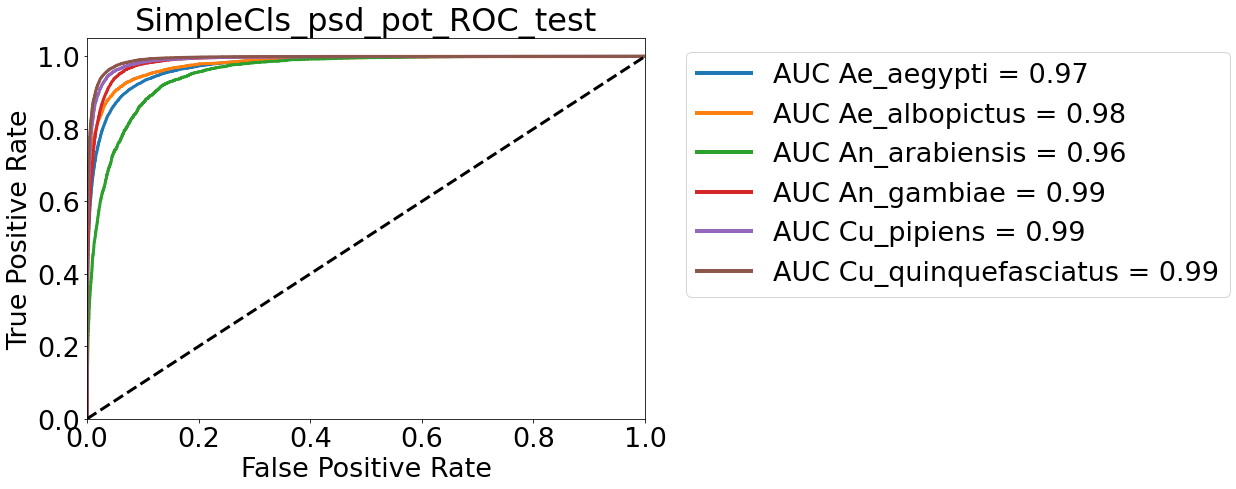

In [ ]:
# Label vector needs to be binarized in order to build ROC
y_test_bin = label_binarize(y_test[:, 1], classes = range(len(species)))
y_pred = model.predict(test_set)

# ROC + AUC
fig = plt.figure(figsize = (10, 7))
plot_roc(y_test_bin, y_pred, species, full_name + '_pot_ROC_test', title_size, ticks_size, label_size)
fig.savefig(histories_dir + full_name + '_pot_roc.eps', bbox_inches = 'tight')
plt.show()

Worst arabiensis predictions

In [ ]:
# Highest predicted probabilities
y_pred_max = np.max(y_pred, axis = -1)
# Indexes of true arabiensis labels
true_arab_ind = np.where(y_test[:,1] == 1)[0]
# Indexes of arab. false negatives 
arab_fn_ind = np.where(pred_specs[true_arab_ind] != 1)[0]
# Indexes of arab. false negatives (within true indexes)
missed_arab_ind = true_arab_ind[ arab_fn_ind ]
# Probabilities of missed arab.
y_pred_max_arab_fn = y_pred_max[missed_arab_ind]
# What species was predicted instead?
y_pred_argmax_arab_fn = pred_specs[missed_arab_ind]
# Misclassified arab. signals
X_test_arab_fn = np.asarray(X_test)[missed_arab_ind]
# Worst misclassifications (with highest certainties for another class)
worst_ind = np.argsort(y_pred_max_arab_fn)[-12:]

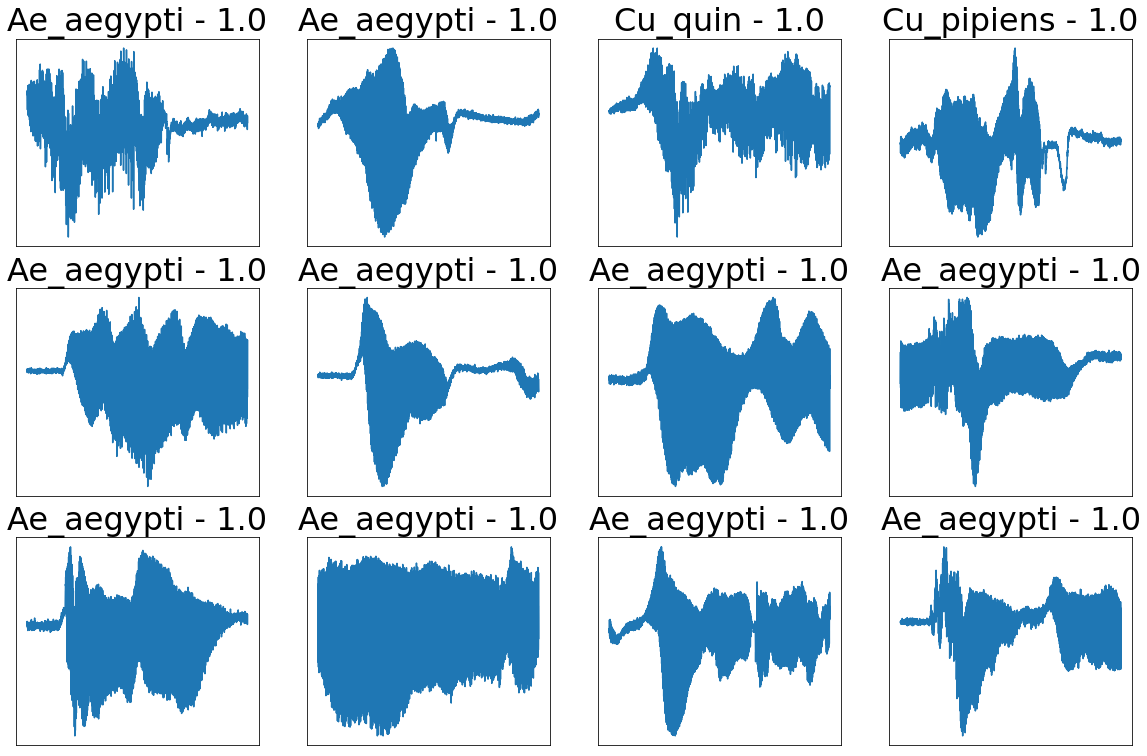

In [ ]:
num_rows  = np.ceil(len(worst_ind) / 4)
fig = plt.figure(figsize = (20, 4 * num_rows + 1))

for i in range(len(worst_ind)):
  plt.subplot(num_rows, 4, i+1)
  plt.plot(X_test_arab_fn[worst_ind[i]])
  pred_spec_ind = y_pred_argmax_arab_fn[worst_ind[i]]
  if pred_spec_ind == 5:
    pred_spec = 'Cu_quin'
  else:
    pred_spec = species[ pred_spec_ind ] 
  certainty = np.round(y_pred_max_arab_fn[worst_ind[i]], 2)
  plt.title(pred_spec + ' - ' + str(certainty), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(histories_dir + full_name + '_pot_worst_arab.eps', bbox_inches = 'tight')
plt.show()

### SimpleEmbCls

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, test_set, model_name, genus_mapping, emb_matrix)

y_test = np.asarray(y_test)
correct_gens  = sum(pred_gens  == y_test[:, 0])
correct_specs = sum(pred_specs == y_test[:, 1])

print(full_name)
print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

SimpleEmbCls_psd
Genus   acc: 0.9008
Species acc: 0.8546


ROC

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_test[:, 0], pred_gens,  normalize = 'true'), 2 )
gen_diags_psd.append( np.diag(gen_conf) )
spec_conf = np.round( confusion_matrix(y_test[:, 1], pred_specs, normalize = 'true'), 2 )
spec_diags_psd.append( np.diag(spec_conf) )

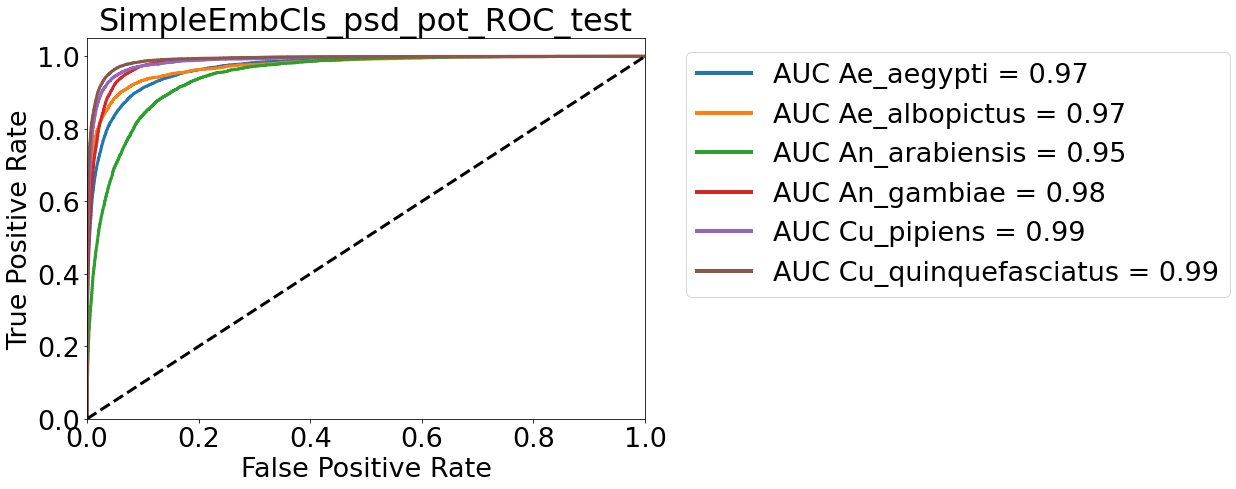

In [ ]:
# Label vector needs to be binarized in order to build ROC
y_test_bin = label_binarize(y_test[:, 1], classes = range(len(species)))
_, y_pred = model.predict(test_set)

# ROC + AUC
fig = plt.figure(figsize = (10, 7))
plot_roc(y_test_bin, y_pred, species, full_name + '_pot_ROC_test', title_size, ticks_size, label_size)
fig.savefig(histories_dir + full_name + '_pot_roc.eps', bbox_inches = 'tight')
plt.show()

Worst arabiensis predictions

In [ ]:
# Highest predicted probabilities
y_pred_max = np.max(y_pred, axis = -1)
# Indexes of true arabiensis labels
true_arab_ind = np.where(y_test[:,1] == 1)[0]
# Indexes of arab. false negatives 
arab_fn_ind = np.where(pred_specs[true_arab_ind] != 1)[0]
# Indexes of arab. false negatives (within true indexes)
missed_arab_ind = true_arab_ind[ arab_fn_ind ]
# Probabilities of missed arab.
y_pred_max_arab_fn = y_pred_max[missed_arab_ind]
# What species was predicted instead?
y_pred_argmax_arab_fn = pred_specs[missed_arab_ind]
# Misclassified arab. signals
X_test_arab_fn = np.asarray(X_test)[missed_arab_ind]
# Worst misclassifications (with highest certainties for another class)
worst_ind = np.argsort(y_pred_max_arab_fn)[-12:]

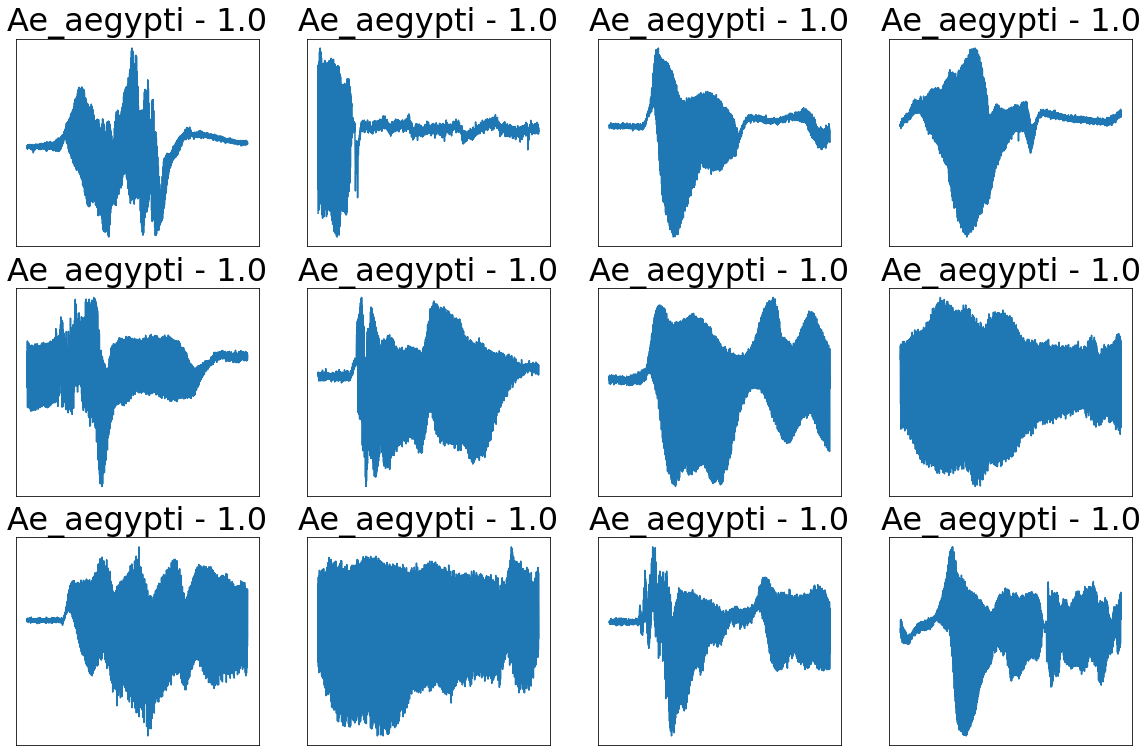

In [ ]:
num_rows  = np.ceil(len(worst_ind) / 4)
fig = plt.figure(figsize = (20, 4 * num_rows + 1))

for i in range(len(worst_ind)):
  plt.subplot(num_rows, 4, i+1)
  plt.plot(X_test_arab_fn[worst_ind[i]])
  pred_spec_ind = y_pred_argmax_arab_fn[worst_ind[i]]
  if pred_spec_ind == 5:
    pred_spec = 'Cu_quin'
  else:
    pred_spec = species[ pred_spec_ind ] 
  certainty = np.round(y_pred_max_arab_fn[worst_ind[i]], 2)
  plt.title(pred_spec + ' - ' + str(certainty), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(histories_dir + full_name + '_pot_worst_arab.eps', bbox_inches = 'tight')
plt.show()

### HieraCls

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, test_set, model_name, genus_mapping, emb_matrix)

y_test = np.asarray(y_test)
correct_gens  = sum(pred_gens  == y_test[:, 0])
correct_specs = sum(pred_specs == y_test[:, 1])

print(full_name)
print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

HieraCls_psd
Genus   acc: 0.9065
Species acc: 0.8647


ROC

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_test[:, 0], pred_gens,  normalize = 'true'), 2 )
gen_diags_psd.append( np.diag(gen_conf) )
spec_conf = np.round( confusion_matrix(y_test[:, 1], pred_specs, normalize = 'true'), 2 )
spec_diags_psd.append( np.diag(spec_conf) )

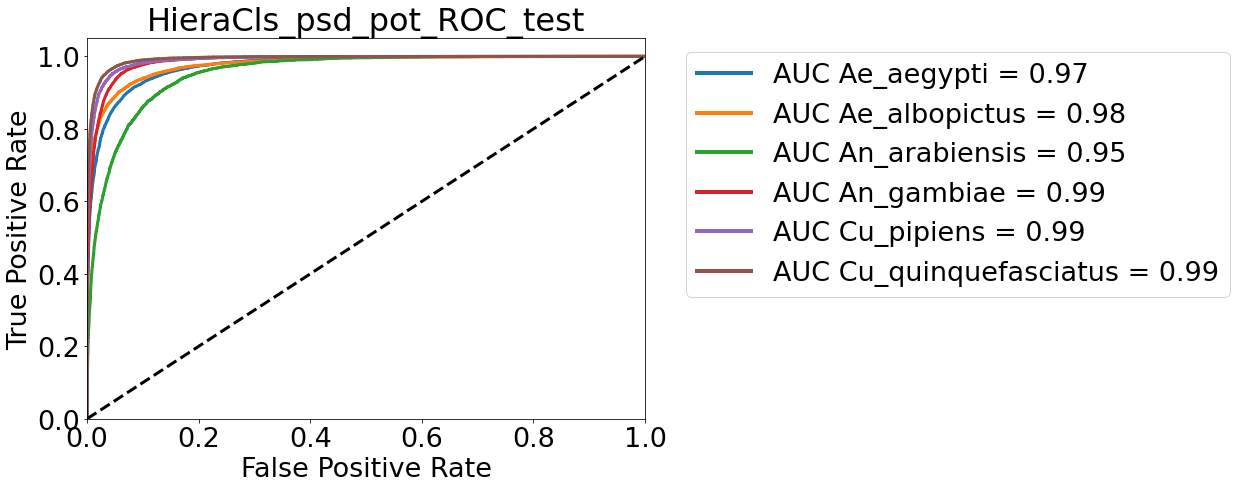

In [ ]:
# Label vector needs to be binarized in order to build ROC
y_test_bin = label_binarize(y_test[:, 1], classes = range(len(species)))
_, y_pred = model.predict(test_set)

# ROC + AUC
fig = plt.figure(figsize = (10, 7))
plot_roc(y_test_bin, y_pred, species, full_name + '_pot_ROC_test', title_size, ticks_size, label_size)
fig.savefig(histories_dir + full_name + '_pot_roc.eps', bbox_inches = 'tight')
plt.show()

Worst arabiensis predictions

In [ ]:
# Highest predicted probabilities
y_pred_max = np.max(y_pred, axis = -1)
# Indexes of true arabiensis labels
true_arab_ind = np.where(y_test[:,1] == 1)[0]
# Indexes of arab. false negatives 
arab_fn_ind = np.where(pred_specs[true_arab_ind] != 1)[0]
# Indexes of arab. false negatives (within true indexes)
missed_arab_ind = true_arab_ind[ arab_fn_ind ]
# Probabilities of missed arab.
y_pred_max_arab_fn = y_pred_max[missed_arab_ind]
# What species was predicted instead?
y_pred_argmax_arab_fn = pred_specs[missed_arab_ind]
# Misclassified arab. signals
X_test_arab_fn = np.asarray(X_test)[missed_arab_ind]
# Worst misclassifications (with highest certainties for another class)
worst_ind = np.argsort(y_pred_max_arab_fn)[-12:]

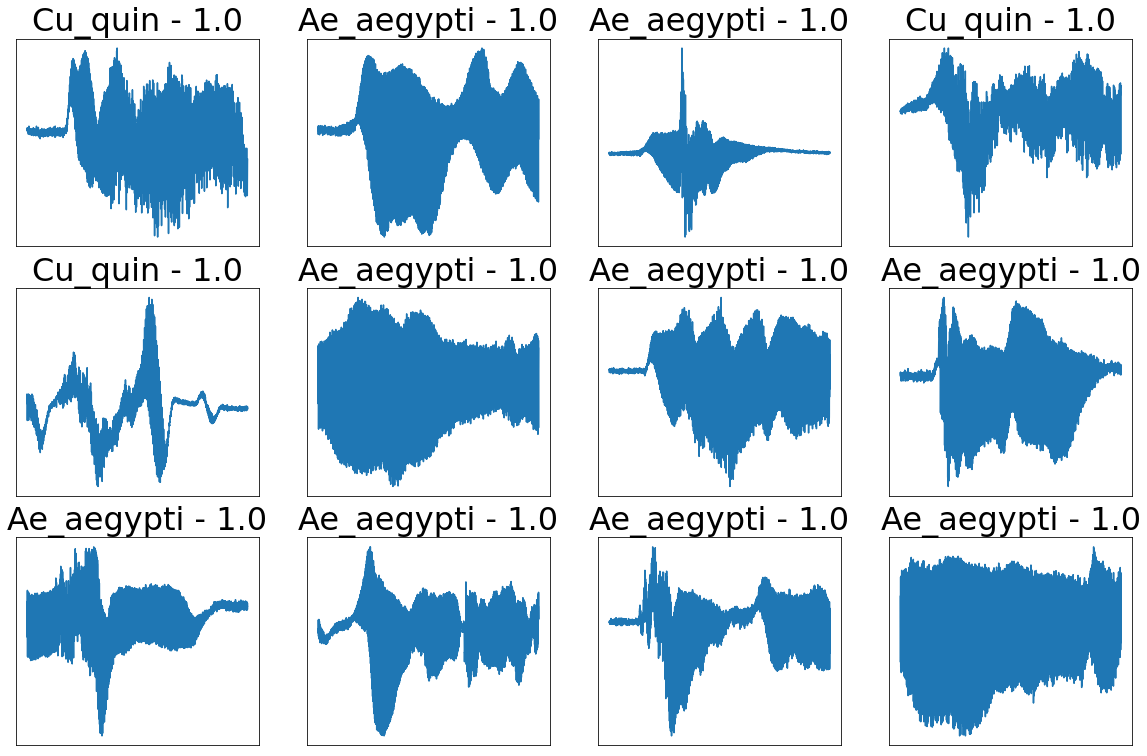

In [ ]:
num_rows  = np.ceil(len(worst_ind) / 4)
fig = plt.figure(figsize = (20, 4 * num_rows + 1))

for i in range(len(worst_ind)):
  plt.subplot(num_rows, 4, i+1)
  plt.plot(X_test_arab_fn[worst_ind[i]])
  pred_spec_ind = y_pred_argmax_arab_fn[worst_ind[i]]
  if pred_spec_ind == 5:
    pred_spec = 'Cu_quin'
  else:
    pred_spec = species[ pred_spec_ind ] 
  certainty = np.round(y_pred_max_arab_fn[worst_ind[i]], 2)
  plt.title(pred_spec + ' - ' + str(certainty), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(histories_dir + full_name + '_pot_worst_arab.eps', bbox_inches = 'tight')
plt.show()

### HieraEmbCls

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, test_set, model_name, genus_mapping, emb_matrix)

y_test = np.asarray(y_test)
correct_gens  = sum(pred_gens  == y_test[:, 0])
correct_specs = sum(pred_specs == y_test[:, 1])

print(full_name)
print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

HieraEmbCls_psd
Genus   acc: 0.9029
Species acc: 0.8556


ROC

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_test[:, 0], pred_gens,  normalize = 'true'), 2 )
gen_diags_psd.append( np.diag(gen_conf) )
spec_conf = np.round( confusion_matrix(y_test[:, 1], pred_specs, normalize = 'true'), 2 )
spec_diags_psd.append( np.diag(spec_conf) )

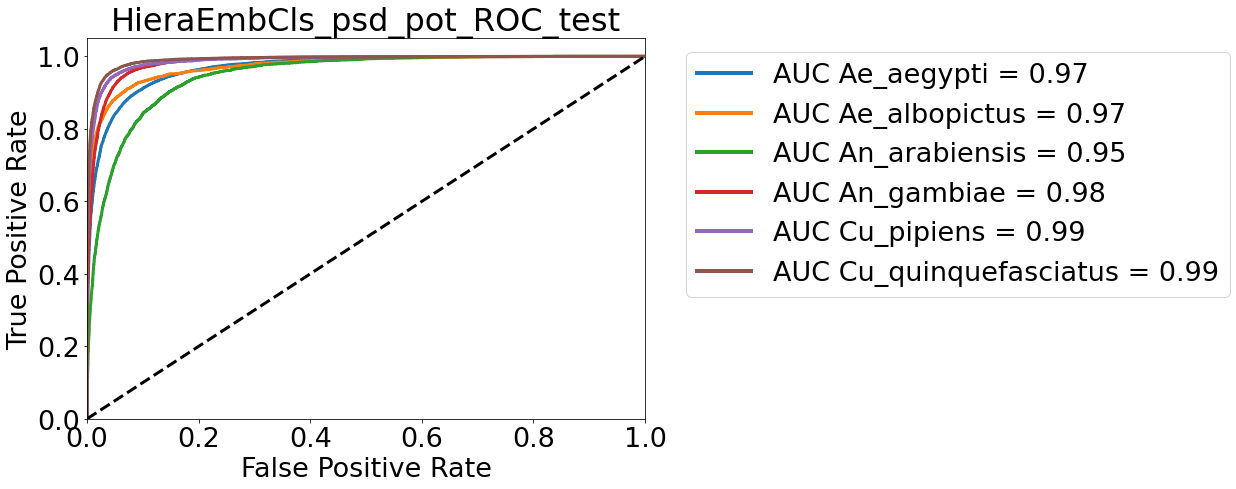

In [ ]:
# Label vector needs to be binarized in order to build ROC
y_test_bin = label_binarize(y_test[:, 1], classes = range(len(species)))
_, _, y_pred = model.predict(test_set)

# ROC + AUC
fig = plt.figure(figsize = (10, 7))
plot_roc(y_test_bin, y_pred, species, full_name + '_pot_ROC_test', title_size, ticks_size, label_size)
fig.savefig(histories_dir + full_name + '_pot_roc.eps', bbox_inches = 'tight')
plt.show()

Worst arabiensis predictions

In [ ]:
# Highest predicted probabilities
y_pred_max = np.max(y_pred, axis = -1)
# Indexes of true arabiensis labels
true_arab_ind = np.where(y_test[:,1] == 1)[0]
# Indexes of arab. false negatives 
arab_fn_ind = np.where(pred_specs[true_arab_ind] != 1)[0]
# Indexes of arab. false negatives (within true indexes)
missed_arab_ind = true_arab_ind[ arab_fn_ind ]
# Probabilities of missed arab.
y_pred_max_arab_fn = y_pred_max[missed_arab_ind]
# What species was predicted instead?
y_pred_argmax_arab_fn = pred_specs[missed_arab_ind]
# Misclassified arab. signals
X_test_arab_fn = np.asarray(X_test)[missed_arab_ind]
# Worst misclassifications (with highest certainties for another class)
worst_ind = np.argsort(y_pred_max_arab_fn)[-12:]

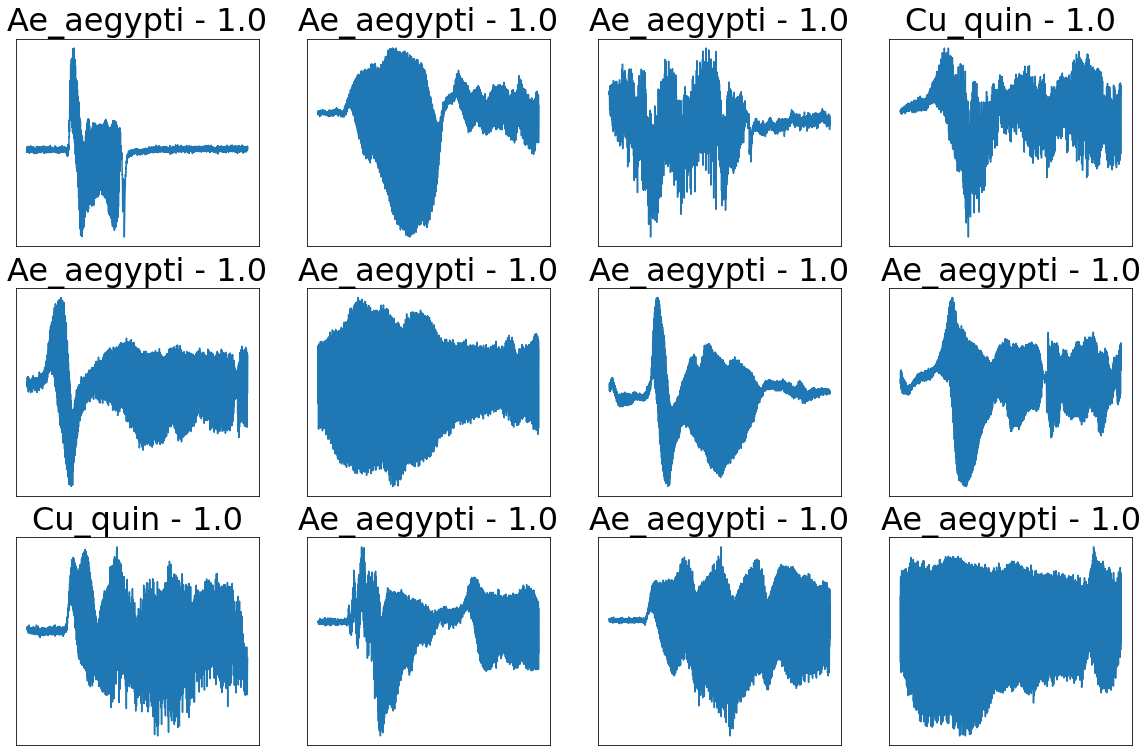

In [ ]:
num_rows  = np.ceil(len(worst_ind) / 4)
fig = plt.figure(figsize = (20, 4 * num_rows + 1))

for i in range(len(worst_ind)):
  plt.subplot(num_rows, 4, i+1)
  plt.plot(X_test_arab_fn[worst_ind[i]])
  pred_spec_ind = y_pred_argmax_arab_fn[worst_ind[i]]
  if pred_spec_ind == 5:
    pred_spec = 'Cu_quin'
  else:
    pred_spec = species[ pred_spec_ind ] 
  certainty = np.round(y_pred_max_arab_fn[worst_ind[i]], 2)
  plt.title(pred_spec + ' - ' + str(certainty), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(histories_dir + full_name + '_pot_worst_arab.eps', bbox_inches = 'tight')
plt.show()

### Voting

In [ ]:
# Choose model to load
inp_form = 'psd'
# Derive psd and path variables
window   = format_params[inp_form]['window']
in_shape = format_params[inp_form]['in_shape']
noverlap = format_params[inp_form]['noverlap']

predictions = np.zeros((len(model_names), len(y_test), len(species)))

In [ ]:
i = 0
for model_name in model_names:

  full_name = model_name + '_' + inp_form
  model_base_dir = pot_models_path + model_name +  '/' + inp_form + '/'
  weights_file   = model_base_dir + full_name + '_frozen.h5'
  print('\n******** ' + full_name + ' ********')

  # Preprocess test set
  test_set = preprocess_dataset(X_test if inp_form == 'spectro' else list(np.copy(X_test)), 
                                y_test, model_name, inp_form, sampling_rate, batch_size,
                                window, nperseg, noverlap, cutoff, shuffle = False, cache = True)
  
  # Roll out models dictionary
  constructor = models_dict[model_name]['constructor']
  out_shape   = models_dict[model_name]['out_shape']
  lr          = models_dict[model_name]['lr_reg'][inp_form][0]
  reg         = models_dict[model_name]['lr_reg'][inp_form][1]
  loss        = models_dict[model_name]['loss']
  metrics     = models_dict[model_name]['metrics']

  # Build and compile
  cnn_name = 'CNN_Blocks_' + model_name
  tf.keras.backend.clear_session() # avoid stacking graphs on one another
  with strategy.scope():
    if inp_form == 'psd':
        cnn = CNN1D(drop_rate, name = cnn_name) # Name needs to be exactly as in Kaggle!
    elif inp_form == 'spectro':
        cnn = CNN2D(drop_rate, name = cnn_name) 

    model = constructor(in_shape, out_shape, cnn, reg, 
                        input_name = inp_form, model_name = full_name, training = False)

    # Note: When loading weights from a frozen model, you need to first also freeze those layers again
    cnn_layer = model.get_layer(cnn_name)
    cnn_layer.bnorm_0.trainable = False
    cnn_layer.block_1.trainable = False
    cnn_layer.block_2.trainable = False

    model.load_weights(weights_file, by_name = True, skip_mismatch = True) 

    # Only now can you unfreeze these layers
    cnn_layer.bnorm_0.trainable = True
    cnn_layer.block_1.trainable = True
    cnn_layer.block_2.trainable = True

    model.compile(tf.keras.optimizers.Adam(lr), loss = loss, metrics = metrics)

  y_pred = model.predict(test_set)
  if len(y_pred) > 1: y_pred = y_pred[-1] # only store species probs.
  predictions[i] = y_pred
  i += 1


******** SimpleCls_psd ********


/content/drive/My Drive/KInsekten/src/processing/preprocessing.py:174: RuntimeWarning: divide by zero encountered in log10
  nperseg = nperseg, noverlap = noverlap))


0
10000
20000
30000
40000
50000
Converted to PSD. New shape: (55916, 129)

******** SimpleEmbCls_psd ********
0
10000
20000
30000
40000
50000
Converted to PSD. New shape: (55916, 129)

******** HieraCls_psd ********
0
10000
20000
30000
40000
50000
Converted to PSD. New shape: (55916, 129)

******** HieraEmbCls_psd ********
0
10000
20000
30000
40000
50000
Converted to PSD. New shape: (55916, 129)


In [ ]:
# Average predictions over classifiers
mean_predictions = np.mean(predictions, axis=0)

# Get predicted labels from voting
pred_specs = np.argmax(mean_predictions, axis=-1)
correct_specs = sum(pred_specs == np.asarray(y_test)[:, 1])

print('Voting PSD')
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Voting PSD
Species acc: 0.8662


## Spectro

### SimpleCls

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, test_set, model_name, genus_mapping, emb_matrix)

y_test = np.asarray(y_test)
correct_gens  = sum(pred_gens  == y_test[:, 0])
correct_specs = sum(pred_specs == y_test[:, 1])

print(full_name)
print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

SimpleCls_spectro
Genus   acc: 0.917
Species acc: 0.8699


ROC

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_test[:, 0], pred_gens,  normalize = 'true'), 2 )
gen_diags_spectro.append( np.diag(gen_conf) )
spec_conf = np.round( confusion_matrix(y_test[:, 1], pred_specs, normalize = 'true'), 2 )
spec_diags_spectro.append( np.diag(spec_conf) )

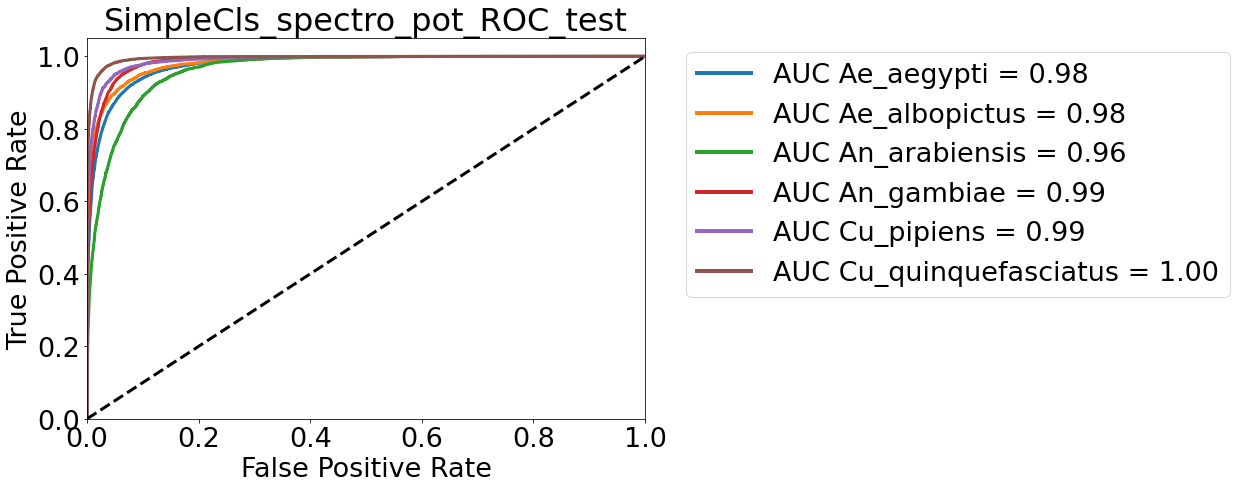

In [ ]:
# Label vector needs to be binarized in order to build ROC
y_test_bin = label_binarize(y_test[:, 1], classes = range(len(species)))
y_pred = model.predict(test_set)

# ROC + AUC
fig = plt.figure(figsize = (10, 7))
plot_roc(y_test_bin, y_pred, species, full_name + '_pot_ROC_test', title_size, ticks_size, label_size)
fig.savefig(histories_dir + full_name + '_pot_roc.eps', bbox_inches = 'tight')
plt.show()

Worst arabiensis predictions

In [ ]:
# Highest predicted probabilities
y_pred_max = np.max(y_pred, axis = -1)
# Indexes of true arabiensis labels
true_arab_ind = np.where(y_test[:,1] == 1)[0]
# Indexes of arab. false negatives 
arab_fn_ind = np.where(pred_specs[true_arab_ind] != 1)[0]
# Indexes of arab. false negatives (within true indexes)
missed_arab_ind = true_arab_ind[ arab_fn_ind ]
# Probabilities of missed arab.
y_pred_max_arab_fn = y_pred_max[missed_arab_ind]
# What species was predicted instead?
y_pred_argmax_arab_fn = pred_specs[missed_arab_ind]
# Misclassified arab. signals
X_test_arab_fn = np.asarray(X_test)[missed_arab_ind]
# Worst misclassifications (with highest certainties for another class)
worst_ind = np.argsort(y_pred_max_arab_fn)[-12:]

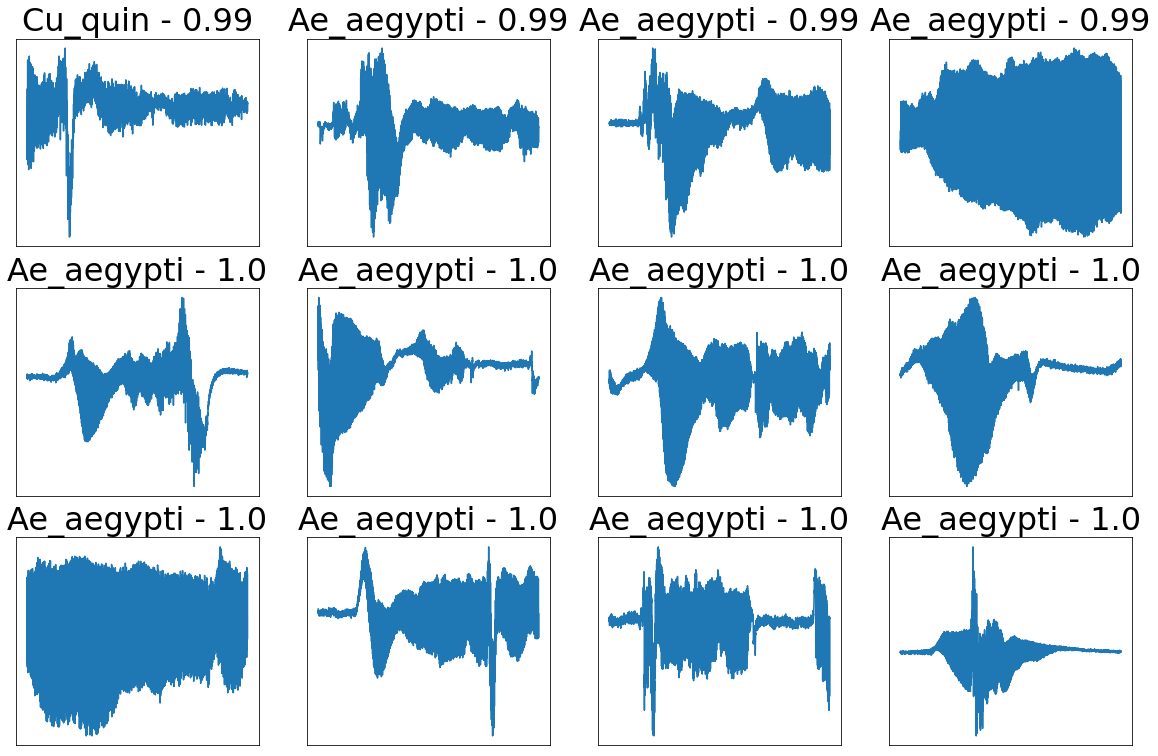

In [ ]:
num_rows  = np.ceil(len(worst_ind) / 4)
fig = plt.figure(figsize = (20, 4 * num_rows + 1))

for i in range(len(worst_ind)):
  plt.subplot(num_rows, 4, i+1)
  plt.plot(X_test_arab_fn[worst_ind[i]])
  pred_spec_ind = y_pred_argmax_arab_fn[worst_ind[i]]
  if pred_spec_ind == 5:
    pred_spec = 'Cu_quin'
  else:
    pred_spec = species[ pred_spec_ind ] 
  certainty = np.round(y_pred_max_arab_fn[worst_ind[i]], 2)
  plt.title(pred_spec + ' - ' + str(certainty), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(histories_dir + full_name + '_pot_worst_arab.eps', bbox_inches = 'tight')
plt.show()

#### MobileNet

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, test_set, model_name, genus_mapping, emb_matrix)

y_test = np.asarray(y_test)
correct_gens  = sum(pred_gens  == y_test[:, 0])
correct_specs = sum(pred_specs == y_test[:, 1])

print(full_name)
print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

SimpleCls_spectro_mobile
Genus   acc: 0.9303
Species acc: 0.886


### SimpleEmbCls

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, test_set, model_name, genus_mapping, emb_matrix)

y_test = np.asarray(y_test)
correct_gens  = sum(pred_gens  == y_test[:, 0])
correct_specs = sum(pred_specs == y_test[:, 1])

print(full_name)
print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

SimpleEmbCls_spectro
Genus   acc: 0.9145
Species acc: 0.8619


ROC

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_test[:, 0], pred_gens,  normalize = 'true'), 2 )
gen_diags_spectro.append( np.diag(gen_conf) )
spec_conf = np.round( confusion_matrix(y_test[:, 1], pred_specs, normalize = 'true'), 2 )
spec_diags_spectro.append( np.diag(spec_conf) )

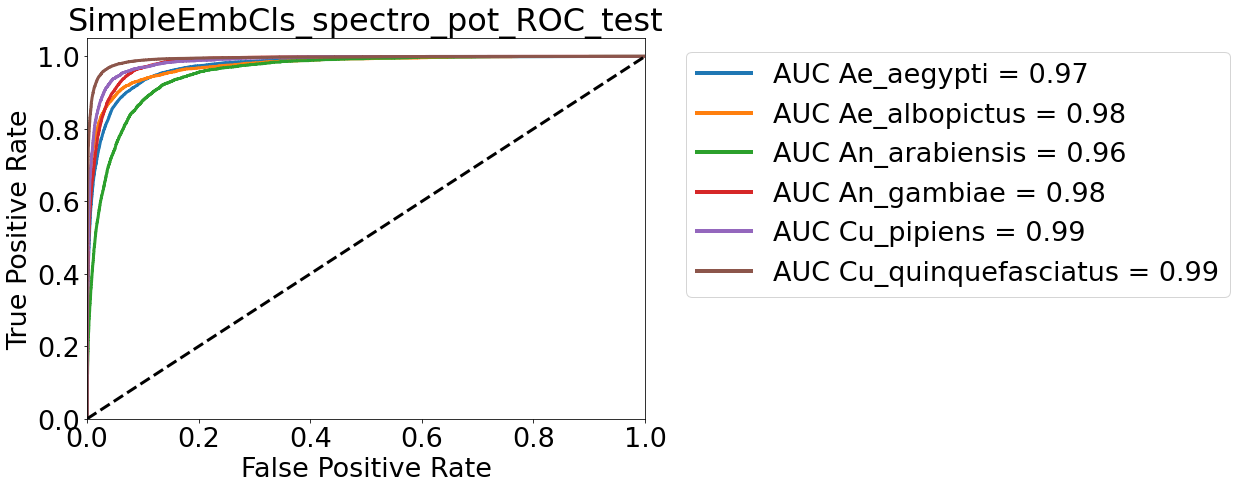

In [ ]:
# Label vector needs to be binarized in order to build ROC
y_test_bin = label_binarize(y_test[:, 1], classes = range(len(species)))
_, y_pred = model.predict(test_set)

# ROC + AUC
fig = plt.figure(figsize = (10, 7))
plot_roc(y_test_bin, y_pred, species, full_name + '_pot_ROC_test', title_size, ticks_size, label_size)
fig.savefig(histories_dir + full_name + '_pot_roc.eps', bbox_inches = 'tight')
plt.show()

Worst arabiensis predictions

In [ ]:
# Highest predicted probabilities
y_pred_max = np.max(y_pred, axis = -1)
# Indexes of true arabiensis labels
true_arab_ind = np.where(y_test[:,1] == 1)[0]
# Indexes of arab. false negatives 
arab_fn_ind = np.where(pred_specs[true_arab_ind] != 1)[0]
# Indexes of arab. false negatives (within true indexes)
missed_arab_ind = true_arab_ind[ arab_fn_ind ]
# Probabilities of missed arab.
y_pred_max_arab_fn = y_pred_max[missed_arab_ind]
# What species was predicted instead?
y_pred_argmax_arab_fn = pred_specs[missed_arab_ind]
# Misclassified arab. signals
X_test_arab_fn = np.asarray(X_test)[missed_arab_ind]
# Worst misclassifications (with highest certainties for another class)
worst_ind = np.argsort(y_pred_max_arab_fn)[-12:]

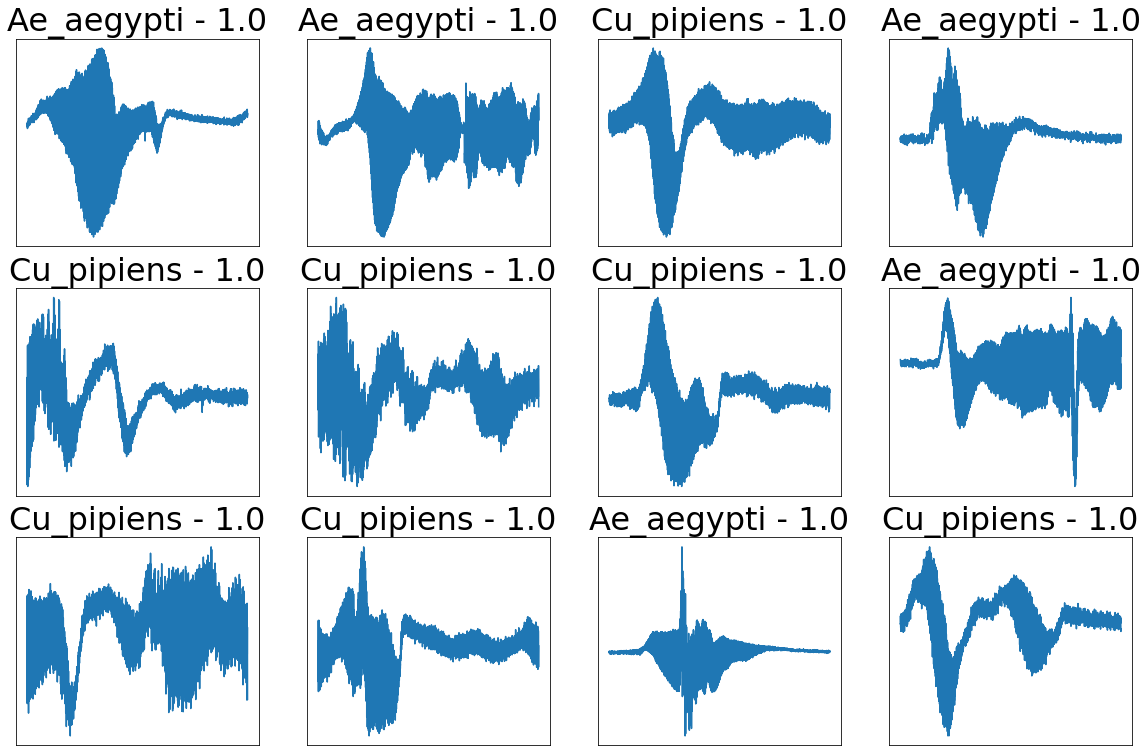

In [ ]:
num_rows  = np.ceil(len(worst_ind) / 4)
fig = plt.figure(figsize = (20, 4 * num_rows + 1))

for i in range(len(worst_ind)):
  plt.subplot(num_rows, 4, i+1)
  plt.plot(X_test_arab_fn[worst_ind[i]])
  pred_spec_ind = y_pred_argmax_arab_fn[worst_ind[i]]
  if pred_spec_ind == 5:
    pred_spec = 'Cu_quin'
  else:
    pred_spec = species[ pred_spec_ind ] 
  certainty = np.round(y_pred_max_arab_fn[worst_ind[i]], 2)
  plt.title(pred_spec + ' - ' + str(certainty), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(histories_dir + full_name + '_pot_worst_arab.eps', bbox_inches = 'tight')
plt.show()

### HieraCls

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, test_set, model_name, genus_mapping, emb_matrix)

y_test = np.asarray(y_test)
correct_gens  = sum(pred_gens  == y_test[:, 0])
correct_specs = sum(pred_specs == y_test[:, 1])

print(full_name)
print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

HieraCls_spectro
Genus   acc: 0.914
Species acc: 0.8669


ROC

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_test[:, 0], pred_gens,  normalize = 'true'), 2 )
gen_diags_spectro.append( np.diag(gen_conf) )
spec_conf = np.round( confusion_matrix(y_test[:, 1], pred_specs, normalize = 'true'), 2 )
spec_diags_spectro.append( np.diag(spec_conf) )

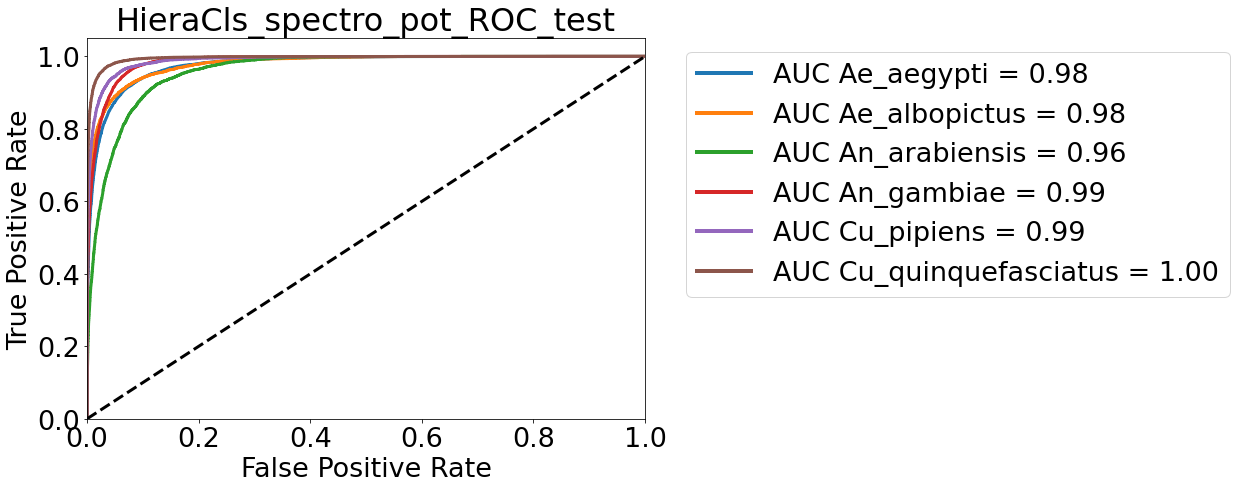

In [ ]:
# Label vector needs to be binarized in order to build ROC
y_test_bin = label_binarize(y_test[:, 1], classes = range(len(species)))
_, y_pred = model.predict(test_set)

# ROC + AUC
fig = plt.figure(figsize = (10, 7))
plot_roc(y_test_bin, y_pred, species, full_name + '_pot_ROC_test', title_size, ticks_size, label_size)
fig.savefig(histories_dir + full_name + '_pot_roc.eps', bbox_inches = 'tight')
plt.show()

Worst arabiensis predictions

In [ ]:
# Highest predicted probabilities
y_pred_max = np.max(y_pred, axis = -1)
# Indexes of true arabiensis labels
true_arab_ind = np.where(y_test[:,1] == 1)[0]
# Indexes of arab. false negatives 
arab_fn_ind = np.where(pred_specs[true_arab_ind] != 1)[0]
# Indexes of arab. false negatives (within true indexes)
missed_arab_ind = true_arab_ind[ arab_fn_ind ]
# Probabilities of missed arab.
y_pred_max_arab_fn = y_pred_max[missed_arab_ind]
# What species was predicted instead?
y_pred_argmax_arab_fn = pred_specs[missed_arab_ind]
# Misclassified arab. signals
X_test_arab_fn = np.asarray(X_test)[missed_arab_ind]
# Worst misclassifications (with highest certainties for another class)
worst_ind = np.argsort(y_pred_max_arab_fn)[-12:]

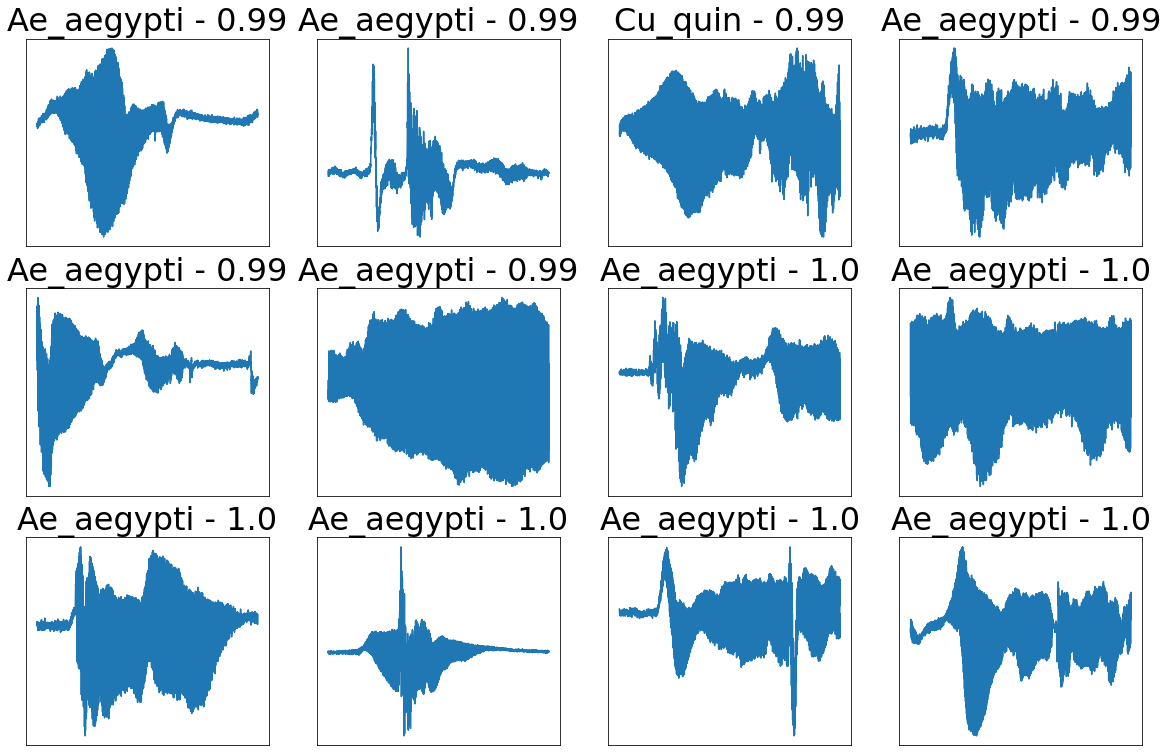

In [ ]:
num_rows  = np.ceil(len(worst_ind) / 4)
fig = plt.figure(figsize = (20, 4 * num_rows + 1))

for i in range(len(worst_ind)):
  plt.subplot(num_rows, 4, i+1)
  plt.plot(X_test_arab_fn[worst_ind[i]])
  pred_spec_ind = y_pred_argmax_arab_fn[worst_ind[i]]
  if pred_spec_ind == 5:
    pred_spec = 'Cu_quin'
  else:
    pred_spec = species[ pred_spec_ind ] 
  certainty = np.round(y_pred_max_arab_fn[worst_ind[i]], 2)
  plt.title(pred_spec + ' - ' + str(certainty), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(histories_dir + full_name + '_pot_worst_arab.eps', bbox_inches = 'tight')
plt.show()

### HieraEmbCls

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, test_set, model_name, genus_mapping, emb_matrix)

y_test = np.asarray(y_test)
correct_gens  = sum(pred_gens  == y_test[:, 0])
correct_specs = sum(pred_specs == y_test[:, 1])

print(full_name)
print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

HieraEmbCls_spectro
Genus   acc: 0.9213
Species acc: 0.864


ROC

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_test[:, 0], pred_gens,  normalize = 'true'), 2 )
gen_diags_spectro.append( np.diag(gen_conf) )
spec_conf = np.round( confusion_matrix(y_test[:, 1], pred_specs, normalize = 'true'), 2 )
spec_diags_spectro.append( np.diag(spec_conf) )

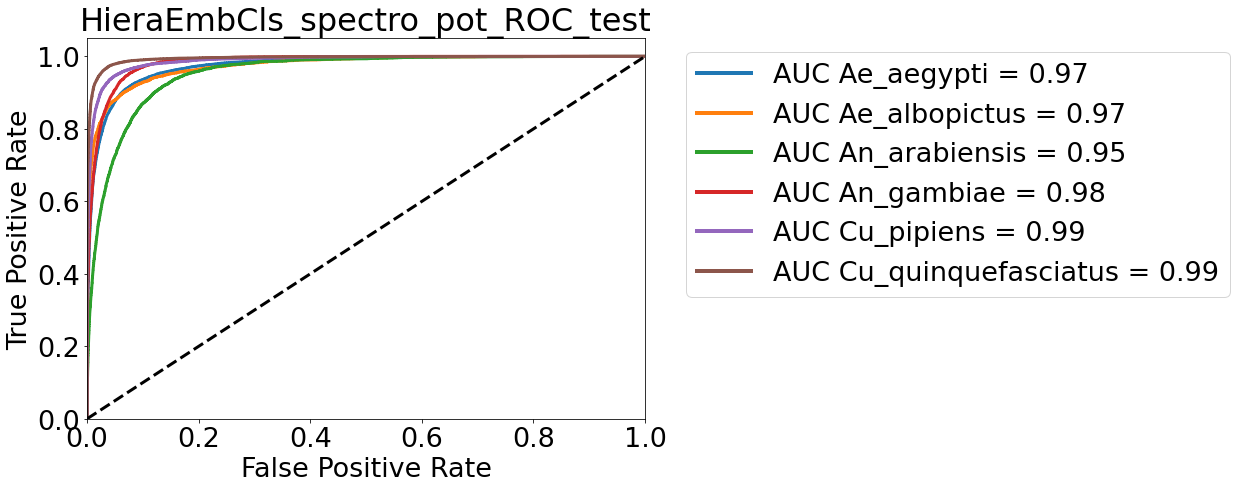

In [ ]:
# Label vector needs to be binarized in order to build ROC
y_test_bin = label_binarize(y_test[:, 1], classes = range(len(species)))
_, _, y_pred = model.predict(test_set)

# ROC + AUC
fig = plt.figure(figsize = (10, 7))
plot_roc(y_test_bin, y_pred, species, full_name + '_pot_ROC_test', title_size, ticks_size, label_size)
fig.savefig(histories_dir + full_name + '_pot_roc.eps', bbox_inches = 'tight')
plt.show()

Worst arabiensis predictions

In [ ]:
# Highest predicted probabilities
y_pred_max = np.max(y_pred, axis = -1)
# Indexes of true arabiensis labels
true_arab_ind = np.where(y_test[:,1] == 1)[0]
# Indexes of arab. false negatives 
arab_fn_ind = np.where(pred_specs[true_arab_ind] != 1)[0]
# Indexes of arab. false negatives (within true indexes)
missed_arab_ind = true_arab_ind[ arab_fn_ind ]
# Probabilities of missed arab.
y_pred_max_arab_fn = y_pred_max[missed_arab_ind]
# What species was predicted instead?
y_pred_argmax_arab_fn = pred_specs[missed_arab_ind]
# Misclassified arab. signals
X_test_arab_fn = np.asarray(X_test)[missed_arab_ind]
# Worst misclassifications (with highest certainties for another class)
worst_ind = np.argsort(y_pred_max_arab_fn)[-12:]

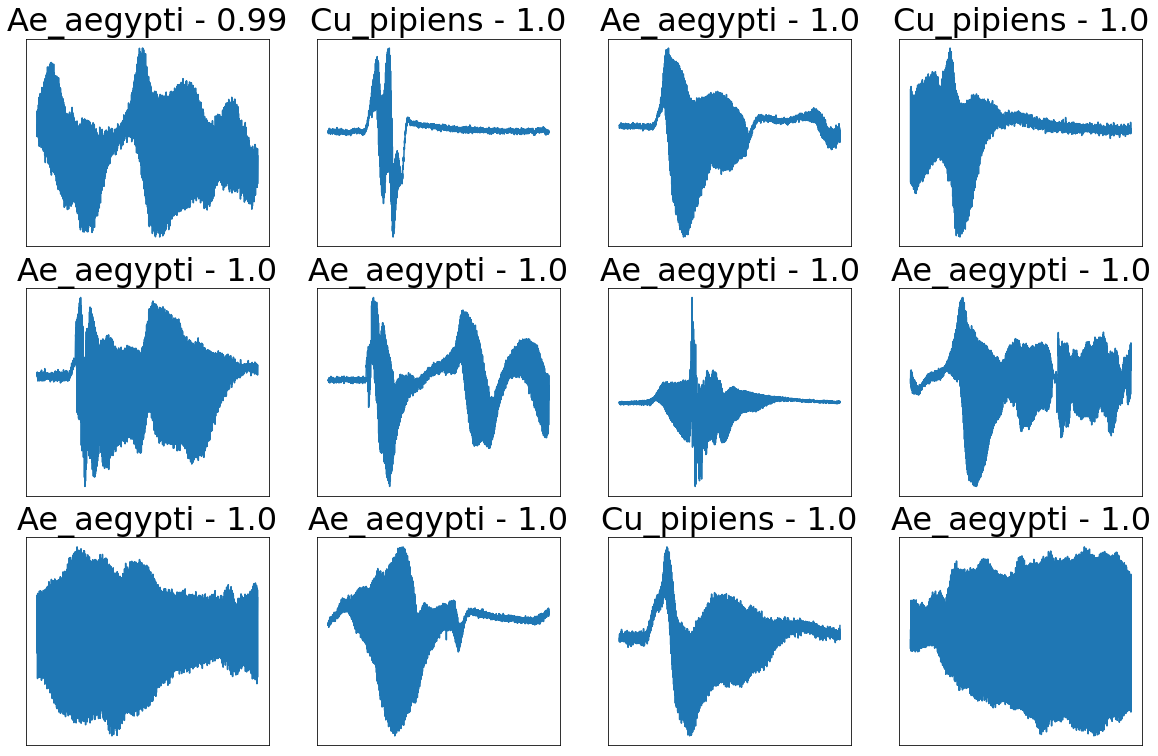

In [ ]:
num_rows  = np.ceil(len(worst_ind) / 4)
fig = plt.figure(figsize = (20, 4 * num_rows + 1))

for i in range(len(worst_ind)):
  plt.subplot(num_rows, 4, i+1)
  plt.plot(X_test_arab_fn[worst_ind[i]])
  pred_spec_ind = y_pred_argmax_arab_fn[worst_ind[i]]
  if pred_spec_ind == 5:
    pred_spec = 'Cu_quin'
  else:
    pred_spec = species[ pred_spec_ind ] 
  certainty = np.round(y_pred_max_arab_fn[worst_ind[i]], 2)
  plt.title(pred_spec + ' - ' + str(certainty), fontsize = title_size)
  plt.xticks([])
  plt.yticks([])
fig.savefig(histories_dir + full_name + '_pot_worst_arab.eps', bbox_inches = 'tight')
plt.show()

### Voting

In [ ]:
# Choose model to load
inp_form = 'spectro'
# Derive psd and path variables
window   = format_params[inp_form]['window']
in_shape = format_params[inp_form]['in_shape']
noverlap = format_params[inp_form]['noverlap']

predictions = np.zeros((len(model_names), len(y_test), len(species)))

In [ ]:
i = 0
for model_name in model_names:

  full_name = model_name + '_' + inp_form
  model_base_dir = pot_models_path + model_name +  '/' + inp_form + '/'
  weights_file   = model_base_dir + full_name + '_frozen.h5'
  print('\n******** ' + full_name + ' ********')

  # Preprocess test set
  test_set = preprocess_dataset(X_test if inp_form == 'spectro' else list(np.copy(X_test)), 
                                y_test, model_name, inp_form, sampling_rate, batch_size,
                                window, nperseg, noverlap, cutoff, shuffle = False, cache = True)
  
  # Roll out models dictionary
  constructor = models_dict[model_name]['constructor']
  out_shape   = models_dict[model_name]['out_shape']
  lr          = models_dict[model_name]['lr_reg'][inp_form][0]
  reg         = models_dict[model_name]['lr_reg'][inp_form][1]
  loss        = models_dict[model_name]['loss']
  metrics     = models_dict[model_name]['metrics']

  # Build and compile
  cnn_name = 'CNN_Blocks_' + model_name
  tf.keras.backend.clear_session() # avoid stacking graphs on one another
  with strategy.scope():
    if inp_form == 'psd':
        cnn = CNN1D(drop_rate, name = cnn_name) # Name needs to be exactly as in Kaggle!
    elif inp_form == 'spectro':
        cnn = CNN2D(drop_rate, name = cnn_name) 

    model = constructor(in_shape, out_shape, cnn, reg, 
                        input_name = inp_form, model_name = full_name, training = False)

    # Note: When loading weights from a frozen model, you need to first also freeze those layers again
    cnn_layer = model.get_layer(cnn_name)
    cnn_layer.bnorm_0.trainable = False
    cnn_layer.block_1.trainable = False
    cnn_layer.block_2.trainable = False

    model.load_weights(weights_file, by_name = True, skip_mismatch = True) 

    # Only now can you unfreeze these layers
    cnn_layer.bnorm_0.trainable = True
    cnn_layer.block_1.trainable = True
    cnn_layer.block_2.trainable = True

    model.compile(tf.keras.optimizers.Adam(lr), loss = loss, metrics = metrics)

  y_pred = model.predict(test_set)
  if len(y_pred) > 1: y_pred = y_pred[-1] # only store species probs.
  predictions[i] = y_pred
  i += 1


******** SimpleCls_spectro ********

******** SimpleEmbCls_spectro ********

******** HieraCls_spectro ********

******** HieraEmbCls_spectro ********


In [ ]:
# Average predictions over classifiers
mean_predictions = np.mean(predictions, axis=0)

# Get predicted labels from voting
pred_specs = np.argmax(mean_predictions, axis=-1)
correct_specs = sum(pred_specs == np.asarray(y_test)[:, 1])

print('Voting Spectro')
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Voting Spectro
Species acc: 0.8809


## Double barplots

In [ ]:
# Accuracies (%)
spec_diags_psd_percent, spec_diags_spectro_percent = [], []
for diag_list_psd, diag_list_spectro in zip(spec_diags_psd, spec_diags_spectro):
  temp_psd, temp_spectro = diag_list_psd.copy(), diag_list_spectro.copy()
  for i in range(len(temp_psd)):
    temp_psd[i], temp_spectro[i] = 100*temp_psd[i], 100*temp_spectro[i]
  spec_diags_psd_percent.append(np.asarray(temp_psd, dtype=np.int16))
  spec_diags_spectro_percent.append(np.asarray(temp_spectro, dtype=np.int16))

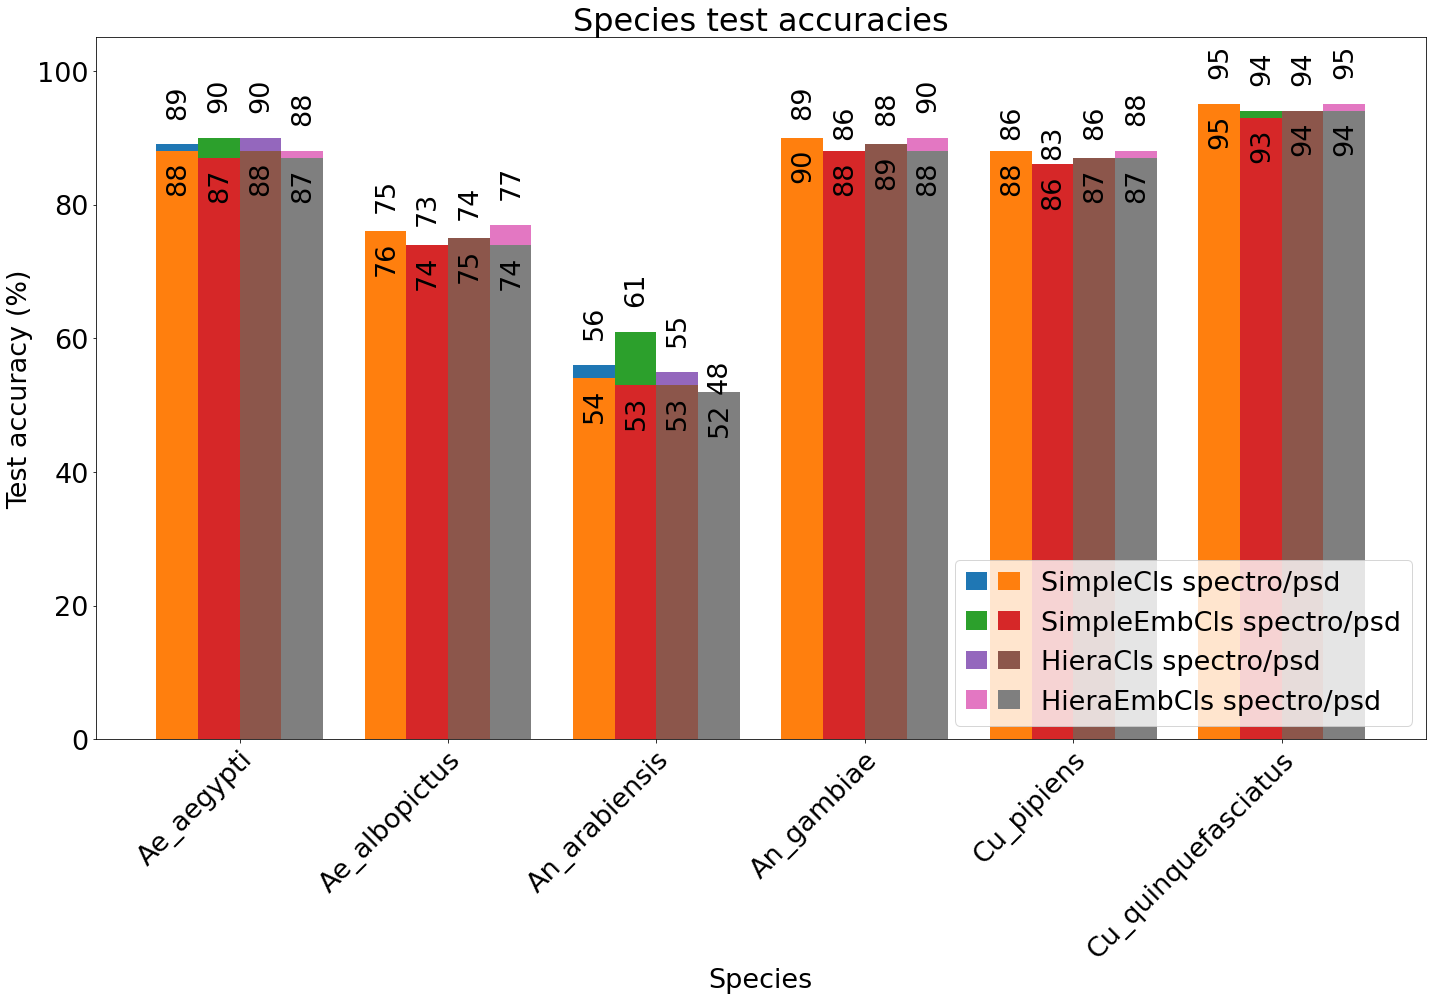

In [ ]:
x = np.arange(len(species))  # the label locations
width = 0.20  # the width of the bars

rects = []
fig = plt.figure(figsize = (20, 14))
for i in range(len(model_names)):
  rect1 = plt.bar(x + i*width, spec_diags_spectro_percent[i],     width, label = model_names[i])
  autolabel(rect1, (1, 60), label_size)
  rect2 = plt.bar(x + i*width, spec_diags_psd_percent[i], width, label = model_names[i])
  autolabel(rect2, (1, -10), label_size)
  rects.append((rect1, rect2))

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Species', fontsize = label_size)
plt.ylabel('Test accuracy (%)', fontsize = label_size)
plt.title('Species test accuracies', fontsize = title_size)
plt.xticks(ticks = x + 1.5*width, labels = species, fontsize = ticks_size,
           rotation = 45, ha = "right", rotation_mode = "anchor")
plt.yticks(fontsize = ticks_size)
plt.ylim(0, 105)
plt.legend(rects, [m_name + ' spectro/psd' for m_name in model_names], 
           fontsize = label_size, loc = 'lower right', handler_map={tuple: HandlerTuple(ndivide=None)})
plt.tight_layout()
fig.savefig(pot_models_path + 'pot_spec_barplots.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Accuracies (%)
gen_diags_psd_percent, gen_diags_spectro_percent = [], []
for diag_list_psd, diag_list_spectro in zip(gen_diags_psd, gen_diags_spectro):
  temp_psd, temp_spectro = diag_list_psd.copy(), diag_list_spectro.copy()
  for i in range(len(temp_psd)):
    temp_psd[i], temp_spectro[i] = 100*temp_psd[i], 100*temp_spectro[i]
  gen_diags_psd_percent.append(np.asarray(temp_psd, dtype=np.int16))
  gen_diags_spectro_percent.append(np.asarray(temp_spectro, dtype=np.int16))

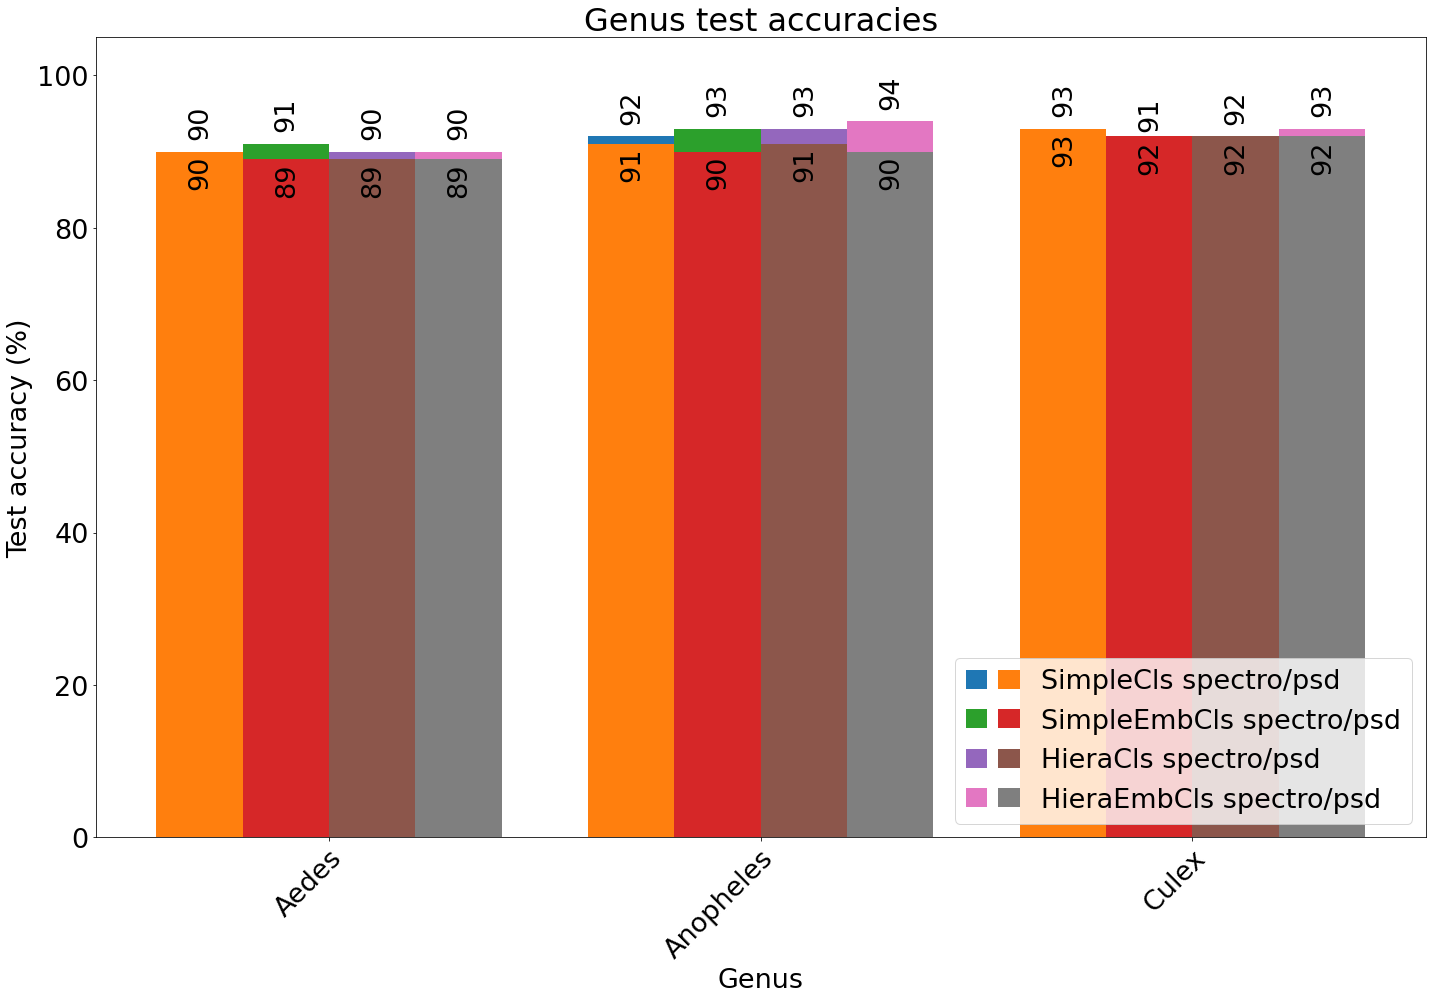

In [ ]:
x = np.arange(len(genus))  # the label locations
width = 0.20  # the width of the bars  

rects = []
fig = plt.figure(figsize = (20, 14))
for i in range(len(model_names)):
  rect1 = plt.bar(x + i*width, gen_diags_spectro_percent[i],     width, label = model_names[i])
  autolabel(rect1, (1, 47), label_size)
  rect2 = plt.bar(x + i*width, gen_diags_psd_percent[i], width, label = model_names[i])
  autolabel(rect2, (1, -3), label_size)
  rects.append((rect1, rect2))

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Genus', fontsize = label_size)
plt.ylabel('Test accuracy (%)', fontsize = label_size)
plt.title('Genus test accuracies', fontsize = title_size)
plt.xticks(ticks = x + 1.5*width, labels = genus, fontsize = ticks_size,
           rotation = 45, ha = "right", rotation_mode = "anchor")
plt.yticks(fontsize = ticks_size)
plt.ylim(0, 105)
plt.legend(rects, [m_name + ' spectro/psd' for m_name in model_names], 
           fontsize = label_size, loc = 'lower right', handler_map={tuple: HandlerTuple(ndivide=None)})
plt.tight_layout()
fig.savefig(pot_models_path + 'pot_gen_barplots.eps', bbox_inches = 'tight')
plt.show()